# Import required libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
import os
os.chdir('/content/drive/My Drive/DataTerps-Project')

# Extract required data from CSV files

In [17]:
employee_data = pd.read_csv("data/Executive_IRS_2024_2023.csv")
all_companies = pd.read_csv("data/final_all_companies.csv")
all_federal = pd.read_csv("data/grant_details.csv")
company_info = pd.read_csv("data/required_columns.csv")
# filtered_df_federal.to_csv("data/federal_company_data.csv")

In [18]:
employee_data.rename(columns={'Organization Name':'company_names'}, inplace=True)
filtered_df_federal = employee_data.merge(all_federal, how="inner", on="company_names")
company_info.rename(columns={"Unique ID":"uei"}, inplace=True)
company_info.rename(columns={"Legal_Business_Name":"company_names"}, inplace=True)

# Creating seperate list of Federal and Non-Federal companies
federal_list = list(all_federal["company_names"].unique())
non_federal_list = list(set(all_companies["Organization Name"]) - set(federal_list))

# Selecting only companies for which we have executive data
filtered_df_non_federal = employee_data[employee_data["company_names"].isin(non_federal_list)]

# Merging company properties data with federal grant data
filtered_df_federal = filtered_df_federal.merge(company_info, how="inner", on="uei")

### Merging company properties data with executive data for both Federal Grant receiving and Non Federal receiving companies

In [19]:
filtered_df_federal.columns

Index(['company_names', 'EIN', 'Executive Name', 'Title',
       'Base Compensation ($)', 'Bonus Compensation ($)',
       'Other Compensation ($)', 'Total Compensation ($)', 'Source File',
       'year', 'uei', 'grants', 'index', 'Cage', 'Purpose of Registration',
       'Registration Date', 'Activation Date', 'Legal Business Name',
       'Physical Address', 'City', 'State', 'Zip Code', 'Country Code',
       'Entity Structure', 'State of Incorporation', 'Business Type',
       'Buyer/Seller Role', 'Govt Credit Card Payment'],
      dtype='object')

In [20]:
# Grouping data by company. Group by 'c_n' and count unique 'co'
group_company = filtered_df_federal.groupby("company_names")
result = filtered_df_federal.groupby('company_names')['Country Code'].nunique().reset_index()
result.columns = ['company_names', 'unique_co_count']
result.sort_values(by = "unique_co_count", ascending=False)

# Merging federal company properties
filtered_df_federal["grants"].value_counts()

,count
grants,
0.00,25119
3770019.35,5385
10000.00,2817
1000000.00,2762
300000.00,2473
...,...
-31368.35,1
-20000.00,1
265492.00,1


# Merge

In [21]:
# filtered_df_federal = filtered_df_federal.merge(company_info, how="inner", on="uei")
filtered_df_federal.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.95])

filtered_df = filtered_df_federal[filtered_df_federal["grants"]>0]
filtered_df = filtered_df[filtered_df["grants"]<28000000]
filtered_df = filtered_df[filtered_df["grants"]<10000000]

<Axes: >

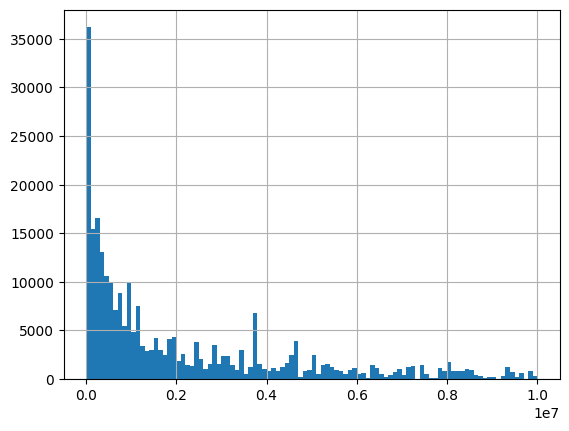

In [22]:
filtered_df["grants"].hist(bins=100)

<Axes: >

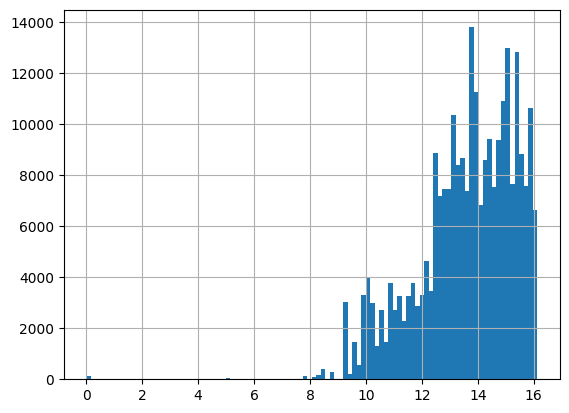

In [23]:

# Replace values in the 'grants' column with their logarithmic values
filtered_df["grants"] = np.log(filtered_df["grants"])
filtered_df["grants"].hist(bins=100)

In [25]:
# Dictionary mapping abbreviations to full forms
abbreviation_map = {
    r"\bDIR\b": "Director",
    r"\bVP\b": "Vice President",
    r"\bCEO\b": "Chief Executive Officer",
    r"\bCFO\b": "Chief Financial Officer",
    r"\bCOO\b": "Chief Operations Officer",
    r"\bSR\.\b": "Senior",
    r"\bPROF\.\b": "Professor",
    r"\bEVP\b": "Executive Vice President",
    r"\bSR\b": "Senior"  # Handles SR without a period
}

# Function to replace abbreviations with full forms
def expand_abbreviations_in_text(text, abbreviation_map):
    for abbr, full_form in abbreviation_map.items():
        text = re.sub(abbr, full_form, text)
    return text

# Example DataFrame
data = {
    "Job Titles": [
        "DIR of Engineering",
        "VP of Marketing",
        "CEO and Founder",
        "CFO of Finance",
        "COO of Operations",
        "SR. Software Engineer",
        "PROF. of Mathematics",
        "EVP of Sales",
        "SR Product Manager",
        "DIRECTOR of Finance"
    ]
}


# Apply the abbreviation expansion to the DataFrame column
filtered_df["Expanded Job Titles"] = filtered_df["Title"].apply(lambda x: expand_abbreviations_in_text(x, abbreviation_map))
filtered_df["Title"] = filtered_df["Title"].str.upper()

In [28]:
# Decode table as a dictionary
decode_table = {
    '2R': 'U.S Federal Government',
    '2F': 'U.S. State Government',
    '12': 'U.S. Local Government',
    '3I': 'Tribal Government',
    'CY': 'Foreign Government',
    'A7': 'AbilityOne Non Profit Agency',
    '20': 'Foreign Owned',
    'JS': 'Small Business Joint Venture',
    '1D': 'Small Agricultural Cooperative',
    'LJ': 'Limited Liability Company',
    'XS': 'Subchapter S Corporation',
    'MF': 'Manufacturer of Goods',
    '2X': 'For Profit Organization',
    'A8': 'Non-Profit Organization',
    '2U': 'Other Not For Profit Organization',
    'HK': 'Community Development Corporation Owned Firm',
    'A3': 'Labor Surplus Area Firm',
    'A5': 'Veteran-Owned Business',
    'QF': 'Service-Disabled Veteran-Owned Business',
    'JV': 'Service-Disabled Veteran-Owned Business Joint Venture',
    'A2': 'Women-Owned Business',
    '23': 'Minority-Owned Business',
    'FR': 'Asian-Pacific American Owned',
    'QZ': 'Subcontinent Asian (Asian-Indian) American Owned',
    'OY': 'Black American Owned',
    'PI': 'Hispanic American Owned',
    'NB': 'Native American Owned',
    '8W': 'Women-Owned Small Business',
    '27': 'Self Certified Small Disadvantaged Business',
    '8C': 'Women-Owned Small Business (WOSB) Joint Venture Eligible under the WOSB Program',
    '8D': 'Economically Disadvantaged Women-Owned Small Business (EDWOSB) Joint Venture',
    'NG': 'Federal Agency',
    'QW': 'Federally Funded Research and Development Center',
    'C8': 'City',
    'C7': 'County',
    'ZR': 'Inter-municipal',
    'MG': 'Local Government Owned',
    'C6': 'Municipality',
    'H6': 'School District',
    'TW': 'Transit Authority',
    'UD': 'Council of Governments',
    '8B': 'Housing Authorities Public/Tribal',
    '86': 'Interstate Entity',
    'KM': 'Planning Commission',
    'T4': 'Port Authority',
    'H2': 'Community Development Corporation',
    '6D': 'Domestic Shelter',
    'M8': 'Educational Institution',
    'G6': '1862 Land Grant College',
    'G7': '1890 Land Grant College',
    'G8': '1994 Land Grant College',
    'HB': 'Historically Black College or University',
    '1A': 'Minority Institution',
    '1R': 'Private University or College',
    'ZW': 'School of Forestry',
    'GW': 'Hispanic Servicing Institution',
    'OH': 'State Controlled Institution of Higher Learning',
    'HS': 'Tribal College',
    'QU': 'Veterinary College',
    'G3': 'Alaskan Native Servicing Institution',
    'G5': 'Native Hawaiian Servicing Institution',
    'BZ': 'Foundation',
    '80': 'Hospital',
    'FY': 'Veterinary Hospital',
    'HQ': 'DOT Certified DBE',
    '05': 'Alaskan Native Corporation Owned Firm',
    'OW': 'American Indian Owned',
    'XY': 'Indian Tribe (Federally Recognized)',
    '8U': 'Native Hawaiian Organization Owned Firm',
    '1B': 'Tribally Owned Firm',
    'FO': 'Township',
    'TR': 'Airport Authority',
    'G9': 'Individual or concern, other than one of the proceeding',
    'JX': 'Self-Certified HUBZone Joint Venture',
    '1E': 'Indian Economic Enterprise',
    '1S': 'Indian Small Business Economic Enterprise',
    'V2 **': 'Grants',
    'VW **': 'Contracts and Grants',
}



# Function to decode a code string
def decode_codes(code_string):
    codes = code_string.split('~')
    return ', '.join([decode_table.get(code, f"Unknown Code ({code})") for code in codes])

# Apply decoding
filtered_df['Decoded Business Type'] = filtered_df['Business Type'].apply(decode_codes)

# # Display result
# print(df)


In [29]:
filtered_df.to_csv("data/federal_companies_executive_data.csv")